## Generate Embeddings From ECG Signal

### Import Packages

In [1]:
import sys
import warnings
sys.path.append("../")
warnings.filterwarnings("ignore")

from data_class import patient
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from keras.models import load_model
from keras.models import Model
import pandas as pd

### Data Loading

In [2]:
subject_id = 10011365
with open("./sample_patient/%s.pkl"%(subject_id), "rb") as f:
    data = pickle.load(f)
ecg_sig = data.ecg
fs = 500
sig_len = ecg_sig.shape[0]

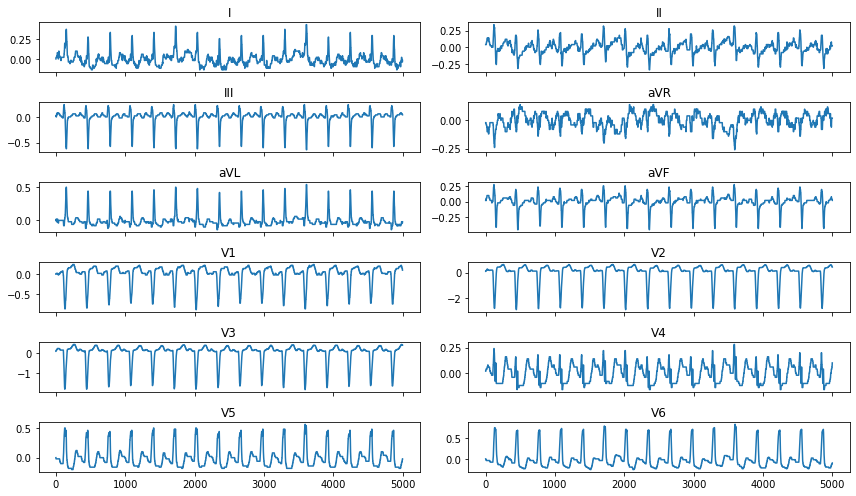

In [3]:
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

fig, ax = plt.subplots(6,2, figsize = (12,7), sharex = True)
for lead_i, lead in enumerate(leads):
    ax[lead_i//2][lead_i%2].plot(ecg_sig[:,lead_i])
    ax[lead_i//2][lead_i%2].set_title(lead)
plt.tight_layout()

In [4]:
#resample to 400Hz
N = int(sig_len/fs * 400)
pad_width = int((4096-N)/2)

def preprocessing(sig):
    sig[np.isnan(sig)] = 0
    return  np.pad(signal.resample(sig,N), pad_width = pad_width)

ecg_sig = np.array([preprocessing(sig) for sig in ecg_sig.transpose()]).transpose()
input = ecg_sig.reshape(1,ecg_sig.shape[0],ecg_sig.shape[1])

### ECG signal embedding extraction¶

In [5]:
model = load_model("./pretrained_models/ecg_diagnosis/model/model.hdf5", compile=False)

prediction_embeddings = model.predict(input)
prediction_embeddings = prediction_embeddings.squeeze()
diagnosis = ["1dAVb", "RBBB", "LBBB", "SB", "AF","ST"]

diagnosis_prediction = pd.DataFrame({"diagnosis":diagnosis, "prediction":prediction_embeddings})
diagnosis_prediction.sort_values(by = ["prediction"], ascending=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


,diagnosis,prediction
2,LBBB,0.749395
4,AF,0.083396
0,1dAVb,0.005286
5,ST,0.002298
1,RBBB,0.000136
3,SB,0.000009


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
(320,)


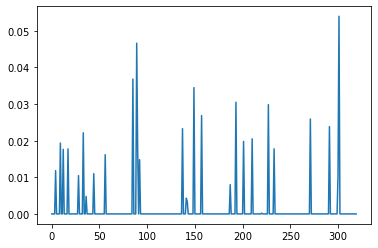

In [6]:
#get output of ResNet last layer
model_embedding = Model(inputs=model.input, outputs=model.layers[-3].output) 
resnet_embeddings = model_embedding.predict(input)

resnet_embeddings = np.max(resnet_embeddings[0],0)
print(resnet_embeddings.shape)
plt.plot(resnet_embeddings)